In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

In [3]:
FLYING_ATTITUDE = 1              # Base altitude (z-value) for flying
INITIAL_PAUSE = 6                # Time (in seconds) for the drone to lift off and stabilize
COMMAND_INTERVAL = 1             # Interval (in seconds) between new movement commands
COMMAND_TOLERANCE = 0.032        # Tolerance (in seconds) for command timing
MOVEMENT_MAGNITUDE = 1.0         # Magnitude of the movement vector in the xy-plane
DRIFT_COEFFICIENT = 0.03         # Lowered drift coefficient to reduce abrupt corrections
ARENA_BOUNDARIES = np.array([[-5, 5],  # x boundaries
                             [-5, 5],  # y boundaries
                             [-5, 5]])      # z boundaries

In [4]:
def adjust_for_boundaries(boundaries, position, movement_vector):
    """
    Adjust the movement vector if the new position would exceed the arena boundaries.

    Rather than reversing the entire movement, this function clips the movement such that the drone
    ends exactly at the boundary if it would otherwise overshoot.

    :param boundaries: Array of shape (3, 2) with lower and upper bounds for x, y, and z.
    :param position: Current 3D position of the drone.
    :param movement_vector: Proposed 3D movement vector [dx, dy, dz].
    :return: Tuple (adjusted 2D movement vector, adjusted z-component).
    """
    new_position = position + movement_vector
    adjusted_vector = movement_vector.copy()
    lower_bounds, upper_bounds = boundaries[:, 0], boundaries[:, 1]
    
    for i in range(3):
        if new_position[i] < lower_bounds[i]:
            adjusted_vector[i] = lower_bounds[i] - position[i]
        elif new_position[i] > upper_bounds[i]:
            adjusted_vector[i] = upper_bounds[i] - position[i]
    return adjusted_vector

def update_direction3D(current_direction, magnitude, dt, angular_std=0.25):
    """
    Update the drone's movement direction in 3D using a small random rotation.
    
    This function performs a random walk on the unit sphere. At each update, the current
    direction is perturbed by a small random rotation about a random axis perpendicular to
    the current direction. The rotation angle is drawn from a normal distribution (scaled by √dt
    for consistency with time resolution), resulting in smooth and continuous changes in direction.
    
    :param current_direction: Current 3D movement vector.
    :param magnitude: Desired magnitude of the new movement vector.
    :param dt: Time step (in seconds).
    :param angular_std: Standard deviation of the angular change (as a fraction of pi).
    :return: Updated 3D movement vector with the specified magnitude.
    """
    norm_curr = np.linalg.norm(current_direction)
    if norm_curr < 1e-6:
        # If current_direction is near zero, choose a random direction uniformly on the sphere.
        random_vec = np.random.randn(3)
        unit_current = random_vec / np.linalg.norm(random_vec)
    else:
        unit_current = current_direction / norm_curr

    # Draw a small random rotation angle (scaled by √dt)
    d_angle = np.random.normal(0, angular_std * np.pi * np.sqrt(dt))
    
    # If the rotation angle is effectively zero, return the current direction (scaled).
    if np.abs(d_angle) < 1e-8:
        return unit_current * magnitude

    # Generate a random vector and project it to get a vector perpendicular to unit_current.
    random_vector = np.random.randn(3)
    perp = random_vector - np.dot(random_vector, unit_current) * unit_current
    perp_norm = np.linalg.norm(perp)
    if perp_norm < 1e-6:
        # Fallback: choose an arbitrary perpendicular vector.
        if np.abs(unit_current[0]) < 0.9:
            perp = np.cross(unit_current, np.array([1, 0, 0]))
        else:
            perp = np.cross(unit_current, np.array([0, 1, 0]))
        perp_norm = np.linalg.norm(perp)
    axis = perp / perp_norm

    # Use Rodrigues rotation formula to compute the rotated vector. simplifies to:
    #   v_rot = v*cos(theta) + (a x v)*sin(theta)
    new_direction = np.cos(d_angle) * unit_current + np.sin(d_angle) * np.cross(axis, unit_current)
    
    return new_direction * magnitude


In [7]:
# ---------------- Main Simulation Loop ----------------
def main(simulated_hours=0.1):
    # Initialize simulation components
    timestep_ms = 32
    dt = timestep_ms / 1000.0  # Convert timestep to seconds
    
    # Initialize state variables
    previous_direction = np.array([0.0, 0.0, 0.0])  # Initial xy movement direction
    elapsed_time = 0
    position_log = []
    velocity_log = []
    current_position = np.array([0.0, 0.0, 1.0])
    
    MAX_SIMULATION_TIME = 3600 * simulated_hours # 1h in seconds * amount of hours
    UPDATE_INTERVAL = MAX_SIMULATION_TIME/10 #define amount of updates by changing denominator

    t = np.arange(0, MAX_SIMULATION_TIME, dt)
    # Main loop: run until simulation termination signal or time limit reached
    #while elapsed_time < MAX_SIMULATION_TIME:
    for _ in tqdm(t):
        elapsed_time += dt  # Update elapsed time in seconds
        movement_direction = np.array([0, 0, 0])
        
        movement_direction = update_direction3D(previous_direction, MOVEMENT_MAGNITUDE, dt, angular_std=0.33)          
        
        # Adjust the movement to respect arena boundaries
        movement_direction = adjust_for_boundaries(ARENA_BOUNDARIES, current_position, movement_direction)

        #movement_direction = (velocity + movement_direction)/2 # use the average between new direction and current velocity for smoothness
        previous_direction = movement_direction  # Use the latest command as the basis for the next direction update
        current_position, velocity = cntr_update(current_position, movement_direction, dt)       
        position_log.append(current_position)
        velocity_log.append(velocity)
    return position_log, velocity_log

In [9]:
def cntr_update(pos, direction, dt):
    pos = pos + direction * dt * np.array([1, 1, 2.5])
    return pos, direction

In [11]:
out = np.array(main(1))
x, y, z = out[0,:,0], out[0,:,1], out[0,:,2]
vec = out[1]

100%|███████████████████████████████████████████████████████████████████████| 112500/112500 [00:06<00:00, 17480.25it/s]


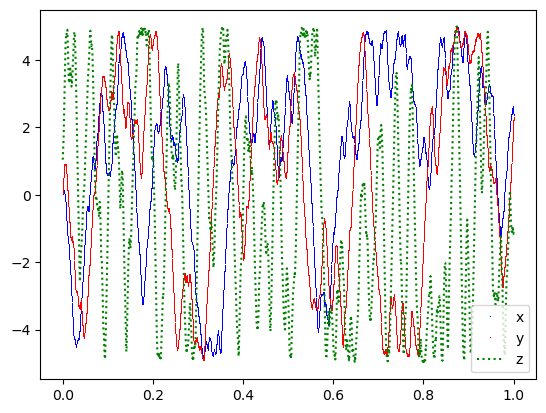

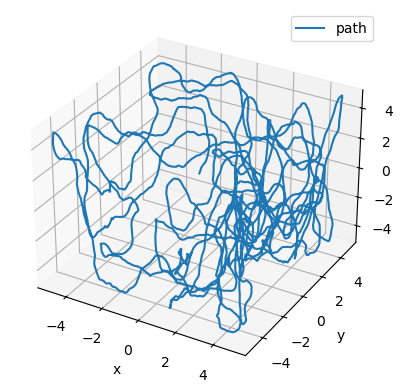

In [12]:
start, stop = 0, 10000
time = np.linspace(start, stop, stop) / stop
plt.plot(time, x[start:stop], 'b,', label='x')
plt.plot(time, y[start:stop], 'r,', label='y')
plt.plot(time, z[start:stop], 'g:', label='z')
plt.legend()

ax = plt.figure().add_subplot(projection='3d')
ax.plot(x[:stop], y[:stop], z[:stop], label='path')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()

plt.show()

In [108]:
mmc = MixedModularCoder(2)
v = np.array([0, 1, 2])
activity = mmc.update(v)

Hello
Distance matrix initialized
Distance matrix initialized
done


In [273]:
mmc = MixedModularCoder(3)
ac_log = []
for i, v in enumerate(tqdm(vec)):
    activity = mmc.update(v)
    ac_log.append(activity)

Hello
Distance matrix initialized
Distance matrix initialized
Distance matrix initialized
done


  0%|                                                                                       | 0/112500 [00:00<?, ?it/s]C:\Users\specsdcn\AppData\Local\Temp\ipykernel_4392\4063042276.py:90: RuntimeWarning: invalid value encountered in divide
  net_activity = ((1 - self.tau) * b_activity + self.tau * (b_activity / np.sum(self.network_activity[a, :])))
100%|█████████████████████████████████████████████████████████████████████████| 112500/112500 [04:46<00:00, 392.71it/s]


In [275]:
pos = out[0]
activity = np.array(ac_log)
X, y, y_pred, mse_mean, r2_mean = fit_linear_model(activity, pos)

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\specsdcn\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\specsdcn\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\specsdcn\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py", line 1242, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\specsdcn\anaconda3\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\specsdcn\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\specsdcn\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1064, in check_array
    _assert_all_finite(
  File "C:\Users\specsdcn\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 123, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "C:\Users\specsdcn\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
Ridge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [248]:
np.shape(X), np.shape(y), np.shape(y_pred)

((112500, 504), (112500, 3), (112500, 3))

In [263]:
mmc.A

array([[[1, 0, 0],
        [0, 1, 0]],

       [[0, 1, 0],
        [0, 0, 1]],

       [[0, 0, 1],
        [1, 0, 0]]])

In [ ]:
stop = 10000
plt.figure(figsize=((10, 8)))
ax = plt.figure().add_subplot(projection='3d')
ax.plot(y[:stop, 0], y[:stop, 1], y[:stop, 2], label='actual path')
ax.plot(y_pred[:stop, 0], y_pred[:stop, 1], y_pred[:stop, 2], label='predicted path')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.show()

In [250]:
np.min(y_pred[:,2]), np.max(y_pred[:,2])

(-0.9749282089625518, 1.0329940964811177)

In [271]:
class MixedModularCoder:
    def __init__(self, M=2, N=3):
        print('Hello')
        #self.A = np.random.normal(size=(M, 2, N))
        #norm = np.linalg.norm(A, axis=(1, 2), keepdims=True)
        #self.A = A / norm
        self.A = np.array([
            [[1, 0, 0], [0,1,0]],
            [[0,1,0], [0,0,1]]
        ])
        nx = 9
        ny = 10
        gains = [0.2, 0.3, 0.4, 0.5, 0.6]
        self.mod_size = nx*ny*len(gains)
        self.Module = []
        for m in range(M):
            self.Module.append(GridNetwork(nx, ny, gains))
        print('done')

    def update(self, velocity):
        activity = np.zeros((self.mod_size,))
        #print(f'shape activity={np.shape(activity)}')
        for m, operator in enumerate(self.A):
            v_mod = operator@velocity
            #print(v_mod)
            activity_mod = self.Module[m].update(v_mod)
            activity = np.append(activity, activity_mod.flatten())
            #print(f'shape mod act = {np.shape(activity_mod)}')
        return activity

In [15]:
class GridNetwork:
    def __init__(self, N_x, N_y, gains=None):
        self.N_x =  N_x
        self.N_y = N_y
        self.N = N_x * N_y # N for one layer, not the whole network
        self.distance_matrix = self.initialize_distance_matrix()

        # params of the (dynamic) weight matrix
        self.I = 0.3                                # intensity parameter (overall synaptic strength)
        self.T = 0.05                               # shift parameter (determining excitatory and inhibitory connections)
        self.sigma = 0.24                           # size of the gaussian
        self.tau = 0.8                              # normalization parameter
        if gains is not None:
            self.gains = gains
        else:
            self.gains = np.arange(1,3.1,0.5)           # Gain parameters (layers of the network)
        self.beta = 0                               # bias parameter (rotation of the grid)
        self.R = np.array([[np.cos(self.beta), -np.sin(self.beta)],[np.sin(self.beta), np.cos(self.beta)]]) # rotation matrix

        # some extra parameters
        self.n = self.N * len(self.gains)           # actual size of the network
        self.seed = 43 
        self.update_network_shape()

    def update_network_shape(self):
        '''Function to update the num of layers (gains) the network has'''
        rng = np.random.default_rng(seed=self.seed) # create a random generator instance (to get locally random seeds)
        self.network_activity = rng.uniform(0, 1 / np.sqrt(self.N), (len(self.gains), self.N))
        
    def initialize_distance_matrix(self):
        ''' Function to initialize the distance matrix between all neurons. 
            Returns a matrix of N by N by 2. The last dimension corresponds to the 2d coordinates.
        '''
        N =  self.N     
        i = np.arange(1, self.N_x+1)
        j = np.arange(1, self.N_y+1)
        x, y = np.meshgrid(i,j) # create x y coordinates (in 2d grids)
        x = np.ravel(x) # np.ravel and .flatten() is, in practice, the same 
        y = np.ravel(y)
        # compute c (position of the cells on the sheet, defined by coordinates c_x and c_y)
        cx = (x - 0.5)/self.N_x
        cy = (np.sqrt(3)/2) * (y - 0.5)/self.N_y
        c = np.array([[cx[i], cy[i]] for i in range(N)]) # list with 2d coordinates (len(c)=N)
        # Initialize ll possible rotations in the twisted toroidal structure
        s_j = [[0, 0], [-0.5, np.sqrt(3)/2], [-0.5,-np.sqrt(3)/2], [0.5, np.sqrt(3)/2],  [0.5, -np.sqrt(3)/2], [-1, 0], [1, 0]]        
        distance_matrix = np.zeros((N,N,2))
        # loop through all combinations of neurons
        for i in range(N):
            for j in range(N):
                min_norm = float('inf')  # Initialize with positive infinity to ensure the first norm is smaller
                for s in s_j: # Iterate over each s_j and compute the norm
                    # Compute the the min norm of the vector c[i] - c[j] + s
                    norm = np.linalg.norm(c[i] - c[j] + s)
                    # Update the minimum norm and its index if the current norm is smaller
                    if norm < min_norm:
                        min_norm = norm # update min norm
                        min_s = s                       
                dist = c[i] - c[j] + min_s
                distance_matrix[i,j] = dist
        print('Distance matrix initialized') 
        return distance_matrix    

    def weight_function(self, I, T, sigma):
        ''' 
        This is to play around with different values of the parameters of the weight function to understand it better. 
        The weight function in the model includes the velocity vector, which here is considered to be 0.
        Params:
                I = intensity parameter, defines the overall synaptic strenght
                sigma = regulates the size of the gaussian
                T = shift parameter determining excitatory and inhibitory connections
        Outputs: Weight matrix
        Note: This functiion is not used to update weights, (there is no input in this one)
              This is just to be able to play with the parameters'''
            
        W = I * np.exp(-(np.linalg.norm(self.distance_matrix, axis=2)**2)/sigma**2) - T      
        return W
   
    def update(self, velocity):
        '''This function is to simulate grid-cell activity in real time'''
        for a, alpha in enumerate(self.gains):  # Iterate over alpha values
            # Update weight matrix based on current velocity and alpha
            W = self.I * np.exp(- (np.linalg.norm(self.distance_matrix + alpha * np.dot(self.R, velocity), axis=2)**2) / self.sigma**2) - self.T
            self.W = W
        
            # Calculate activity using transfer function
            b_activity = self.network_activity[a, :]
            b_activity = b_activity @ W
            
            # Normalize activity
            net_activity = ((1 - self.tau) * b_activity + self.tau * (b_activity / np.sum(self.network_activity[a, :])))
            net_activity[net_activity < 0] = 0 
            if (np.max(net_activity) != np.min(net_activity)): # normalise only if not all values identical
                net_activity = (net_activity - np.min(net_activity)) / (np.max(net_activity) - np.min(net_activity))        
            
            self.network_activity[a, :] = net_activity # save activity for each gain
        
        return self.network_activity

In [134]:
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.linear_model import Ridge, LinearRegression

def fit_linear_model(activity_array, pos, return_shuffled=False, alpha=1.0, cv_folds=10):
    
    np.random.seed(43)

    X = activity_array.reshape(activity_array.shape[0],-1)  # shape is (time, gains*N)
    y = np.array(pos)  # shape is (time, 2)

    # Initialize the Ridge regression model with specified alpha
    model = Ridge(alpha=alpha)
    # model = LinearRegression()

    # Perform K-Fold cross-validation
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Cross-validation scores for MSE
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    # Cross-validation scores for R2
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    # Crossval estimates
    y_pred = cross_val_predict(model, X, y, cv=kf)

    # Compute the average and standard deviation of MSE and R2 scores across folds
    mse_mean = round(np.mean(mse_scores), 5)
    mse_std = round(np.std(mse_scores), 5)
    r2_mean = round(np.mean(r2_scores), 5)
    r2_std = round(np.std(r2_scores), 5)

    if return_shuffled == False:
        # return mse_mean, mse_std, r2_mean, r2_std
        return X, y, y_pred, mse_mean, r2_mean

    else:  # Fit linear model with shuffled labels
        y_shuffled = y.copy()
        np.random.shuffle(y_shuffled)  # Shuffle the labels
        # Cross-validation scores for MSE with shuffled labels
        mse_shuffled_scores = -cross_val_score(model, X, y_shuffled, cv=kf, scoring='neg_mean_squared_error')
        # Cross-validation scores for R2 with shuffled labels
        r2_shuffled_scores = cross_val_score(model, X, y_shuffled, cv=kf, scoring='r2')

        # Compute the average and standard deviation of MSE and R2 scores for shuffled data
        mse_shuffled_mean = round(np.mean(mse_shuffled_scores), 5)
        mse_shuffled_std = round(np.std(mse_shuffled_scores), 5)
        r2_shuffled_mean = round(np.mean(r2_shuffled_scores), 5)
        r2_shuffled_std = round(np.std(r2_shuffled_scores), 5)

        return X, y, y_pred, mse_mean, mse_shuffled_mean, r2_mean, r2_shuffled_mean